# timeseries.py

In [1]:
import vectorbt as vbt
from vectorbt.utils import *

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float64)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
print(ts.fillna(-1))
%timeit big_ts.fillna(-1)

print(ts.vbt.timeseries.fillna(-1))
%timeit big_ts.vbt.timeseries.fillna(-1)

              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
6.79 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
4.95 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
print(ts.shift(3))
%timeit big_ts.shift(3)

print(ts.vbt.timeseries.fshift(3))
%timeit big_ts.vbt.timeseries.fshift(3)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
2.51 ms ± 82.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
4.02 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
print(ts.diff())
%timeit big_ts.diff()

print(ts.vbt.timeseries.diff())
%timeit big_ts.vbt.timeseries.diff()

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
4.95 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
7.58 ms ± 753 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print(ts.pct_change())
%timeit big_ts.pct_change()

print(ts.vbt.timeseries.pct_change())
%timeit big_ts.vbt.timeseries.pct_change()

                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  0.0
2018-01-04  0.333333 -0.333333  0.0
2018-01-05  0.000000 -0.500000 -0.5
333 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
7.43 ms ± 91.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
print(ts.ffill())
%timeit big_ts.ffill()

print(ts.vbt.timeseries.ffill())
%timeit big_ts.vbt.timeseries.ffill()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
6.07 ms ± 332 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
8.7 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
print(ts.cumsum())
%timeit big_ts.cumsum()

print(ts.vbt.timeseries.cumsum())
%timeit big_ts.vbt.timeseries.cumsum()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
12.4 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
8.51 ms ± 40.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
print(ts.cumprod())
%timeit big_ts.cumprod()

print(ts.vbt.timeseries.cumprod())
%timeit big_ts.vbt.timeseries.cumprod()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
12.3 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
8.6 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(ts.rolling(2).mean())
%timeit big_ts.rolling(2).mean()

print(ts.vbt.timeseries.rolling_mean(2))
%timeit big_ts.vbt.timeseries.rolling_mean(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
31.5 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
15.2 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
print(ts.rolling(2).std())
%timeit big_ts.rolling(2).std()

print(ts.vbt.timeseries.rolling_std(2))
%timeit big_ts.vbt.timeseries.rolling_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
61.3 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
19.6 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(ts.rolling(2).min())
%timeit big_ts.rolling(2).min()

print(ts.vbt.timeseries.rolling_min(2))
%timeit big_ts.vbt.timeseries.rolling_min(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
50.5 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
19 ms ± 953 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(ts.rolling(2).max())
%timeit big_ts.rolling(2).max()

print(ts.vbt.timeseries.rolling_max(2))
%timeit big_ts.vbt.timeseries.rolling_max(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
44.3 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
17.3 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(ts.expanding().max())
%timeit big_ts.expanding().max()

print(ts.vbt.timeseries.expanding_max())
%timeit big_ts.vbt.timeseries.expanding_max()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
53.5 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
10.9 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(ts.ewm(span=2).mean())
%timeit big_ts.ewm(span=2).mean()

print(ts.vbt.timeseries.ewm_mean(2))
%timeit big_ts.vbt.timeseries.ewm_mean(2)

                   a         b         c
2018-01-01  1.000000       NaN  1.000000
2018-01-02  1.750000  4.000000  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
102 ms ± 5.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000  4.000000  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
14.7 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
print(ts.ewm(span=2).std())
%timeit big_ts.ewm(span=2).std()

print(ts.vbt.timeseries.ewm_std(2))
%timeit big_ts.vbt.timeseries.ewm_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
524 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
23.2 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
nanmean_nb = njit(lambda x: np.nanmean(x))

print(ts.rolling(3).apply(nanmean_nb, raw=True)) # not correct
%timeit big_ts.rolling(3).apply(nanmean_nb, raw=True)

print(ts.vbt.timeseries.rolling_apply(3, nanmean_nb)) # correct
%timeit big_ts.vbt.timeseries.rolling_apply(3, nanmean_nb)

print(ts.vbt.timeseries.rolling_apply(3, nanmean_nb, on_2d=True))
%timeit big_ts.vbt.timeseries.rolling_apply(3, nanmean_nb, on_2d=True)

              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  NaN NaN
2018-01-03  2.0  NaN NaN
2018-01-04  3.0  3.0 NaN
2018-01-05  NaN  2.0 NaN
431 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  2.0  3.5  1.5
2018-01-04  3.0  3.0  2.0
2018-01-05  3.5  2.0  1.5
49.6 ms ± 803 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.750000  2.750000  2.750000
2018-01-05  2.285714  2.285714  2.285714
7.73 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(ts.expanding().apply(nanmean_nb, raw=True))
%timeit big_ts.expanding().apply(nanmean_nb, raw=True)

print(ts.vbt.timeseries.expanding_apply(nanmean_nb))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_nb)

print(ts.vbt.timeseries.expanding_apply(nanmean_nb, on_2d=True))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_nb, on_2d=True)

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.52 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
891 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.400000  2.400000  2.400000
2018-01-05  2.166667  2.166667  2.166667
880 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(ts['a'].groupby(np.asarray([1, 1, 2, 2, 3])).apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].groupby(np.random.randint(10, size=1000)).apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.groupby(np.asarray([1, 1, 2, 2, 3])).agg({
    'a': lambda x: nanmean_nb(x.values), 
    'b': lambda x: nanmean_nb(x.values), 
    'c': lambda x: nanmean_nb(x.values)})) # any clean way to do column-wise grouping in pandas?

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb, on_2d=True))

1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
4.39 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
475 µs ± 89.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
7.82 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
     a    b    c
1  2.0  2.0  2.0
2  2.8  2.8  2.8
3  1.0  1.0  1.0


In [22]:
print(ts['a'].resample('1h').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb) # 100x faster

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb, on_2d=True))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb, on_2d=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
137 ms ± 9.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
120 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
2018

In [23]:
print(ts['a'].resample('3d').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('3d').apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('3d', nanmean_nb)

print(ts.resample('3d').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.resample('3d').apply(lambda x: nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('3d', nanmean_nb)

2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
3.66 ms ± 45.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
7.77 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
3.46 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
296 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(ts['a'].resample('1w').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1w').apply(lambda x: nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1w', nanmean_nb)

print(ts.resample('1w').apply(lambda x: nanmean_nb(x.values)))
%timeit big_ts.resample('1w').apply(lambda x: nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1w', nanmean_nb)

2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
6.36 ms ± 71.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
8.94 ms ± 92.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-07  2.5  2.5  1.5
2.49 s ± 8.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-07  2.5  2.5  1.5
134 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
print(ts['a'].vbt.timeseries.rolling_range(2, n=2))
%timeit big_ts.iloc[:, 0].vbt.timeseries.rolling_range(2, n=100)

print(ts.vbt.timeseries.rolling_range(2, n=2))
%timeit big_ts.vbt.timeseries.rolling_range(2, n=100)

range_start  2018-01-01  2018-01-04
0                   1.0         4.0
1                   2.0         NaN
854 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
range_start 2018-01-01           2018-01-04          
                     a    b    c          a    b    c
0                  1.0  4.0  NaN        2.0  1.0  2.0
1                  2.0  NaN  4.0        1.0  2.0  1.0
63.6 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


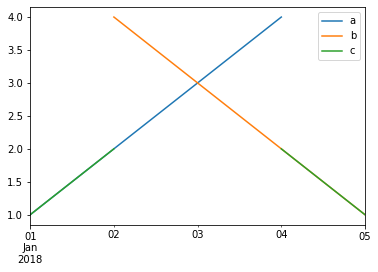

In [26]:
# Two ways of plotting
ts.plot()

In [27]:
ts.vbt.timeseries.plot()

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'a',
              'type': 'scatter',
    …

In [28]:
ts['a'].vbt.timeseries.plot()

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'a',
              'type': 'scatter',
    …

## OHLCV

In [31]:
ohlcv_ts = pd.DataFrame(
    columns=['Open', 'High', 'Low', 'Close', 'Volume'],
    index=[datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
)
ohlcv_ts['Open'] = np.cumsum(np.random.uniform(-0.8, 1, size=(1000,)))
ohlcv_ts['Close'] = ohlcv_ts['Open'] + np.random.uniform(-1, 1, size=(1000,))
ohlcv_ts['High'] = ohlcv_ts['Open'] + np.random.uniform(0, 1, size=(1000,))
ohlcv_ts['Low'] = ohlcv_ts['Open'] - np.random.uniform(0, 1, size=(1000,))
ohlcv_ts['Volume'] = np.cumsum(np.random.uniform(-1, 1, size=(1000,)))

print(ohlcv_ts.head())

                Open      High       Low     Close    Volume
2018-01-01 -0.225892  0.460849 -1.040607  0.458119 -0.645918
2018-01-02  0.021885  0.481961 -0.690531  0.253005 -1.071680
2018-01-03 -0.549334 -0.098237 -1.050758  0.438909 -0.540684
2018-01-04 -0.131453 -0.013180 -0.883006  0.784554  0.284947
2018-01-05  0.213626  0.722338 -0.121478  0.647181 -0.100242


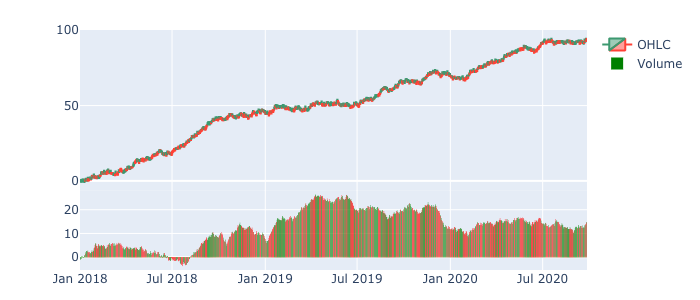

In [33]:
ohlcv_ts = ohlcv_ts.rename(columns={'Volume': 'Volume2'}) # test different column names

ohlcv_ts.vbt.ohlcv(volume='Volume2').plot().show_png()